### 2.2.8. 예제: 우주 왕복선 챌린저호 참사

In [1]:
from IPython.core.pylabtools import figsize
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats as stats
import pymc3 as pm

matplotlib.rc('font', family='Malgun Gothic') # 한글표시
plt.rc('axes', unicode_minus=False) # 마이너스 기호 표시

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
figsize(12.5, 3.5)
np.set_printoptions(precision=3, suppress=True) # float 프린트 옵션 조절

challenger_data = np.genfromtxt('challenger_data.csv', skip_header=1, usecols=[1, 2], missing_values='NA', delimiter=',')

In [3]:
~np.isnan(challenger_data[:, 1])

array([ True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False])

In [4]:
# drop nan
challenger_data = challenger_data[~np.isnan(challenger_data[:, 1])] 

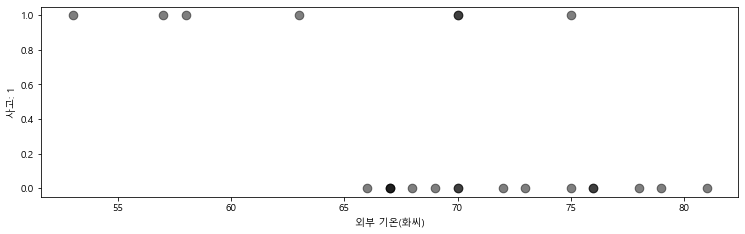

In [5]:
plt.scatter(challenger_data[:, 0], challenger_data[:, 1], s=75, color='k', alpha=.5)
plt.ylabel('사고: 1')
plt.xlabel('외부 기온(화씨)')
plt.show()

- 외부 온도가 낮을수록 피해 사고가 발생할 확률이 증가하는 경향이 보임. 기온과 발생할 사고 사이에 엄격한 구분이 보이지 않으므로 확률로 모델링.
- '온도 t에서 손실사고의 확률은 얼마일까?'에 대한 답을 확인 가능.


- $p(t)$라는 온도 함수가 필요함. 이 함숫값의 범위는 0과 1 사이이고, 온도를 높이면 1부터 0까지 변함. 이런 함수가 실제로 많고, 가장 대중적인 함수는 로지스틱 함수
$$p(t) = \frac 1 {1+e^{\beta t}}$$
- 이 모델에서 $\beta$는 확신이 없는 변수. $\beta=1,3,-5$에 대해 작성한 함수를 아래 그림으로 나타냄

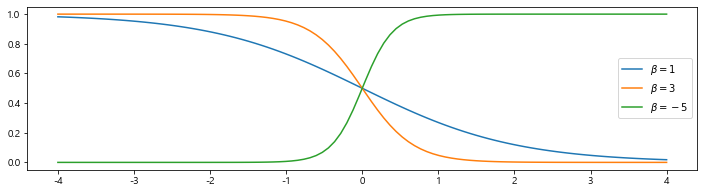

In [6]:
figsize(12, 3)

def logistic(x, beta):
    return 1 / (1+np.exp(beta*x))

x = np.linspace(-4, 4, 100)
plt.plot(x, logistic(x, 1), label=r"$\beta = 1$")
plt.plot(x, logistic(x, 3), label=r"$\beta = 3$")
plt.plot(x, logistic(x, -5), label=r"$\beta = -5$")
plt.legend()

- 로지스틱 함수에서 확률은 0 근처에서 변하는데, 챌린저호 데이터에서는 화씨 65~70도 근처에서 변함. 로지스틱 함수의 bias를 추가해서 변형 가능.
$$p(t)=\frac 1 {1+e^{\beta t + \alpha}}$$

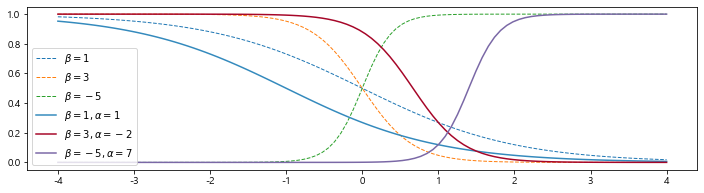

In [7]:
def logistic(x, beta, alpha=0):
    return 1.0 / (1.0 + np.exp(np.dot(beta, x) + alpha))

x = np.linspace(-4, 4, 100)

plt.plot(x, logistic(x, 1), label=r"$\beta = 1$", ls="--", lw=1)
plt.plot(x, logistic(x, 3), label=r"$\beta = 3$", ls="--", lw=1)
plt.plot(x, logistic(x, -5), label=r"$\beta = -5$", ls="--", lw=1)

plt.plot(x, logistic(x, 1, 1), label=r"$\beta = 1, \alpha = 1$",
         color="#348ABD")
plt.plot(x, logistic(x, 3, -2), label=r"$\beta = 3, \alpha = -2$",
         color="#A60628")
plt.plot(x, logistic(x, -5, 7), label=r"$\beta = -5, \alpha = 7$",
         color="#7A68A6")

plt.legend(loc="lower left");

- 상수항 $\alpha$를 추가하여 곡선을 왼쪽 또는 오른쪽으로 이동시킴(그래서 bias라고 함)
- pymc에서 이를 모델링. $\beta$, $\alpha$ 모수들은 양수이거나, 구간이 있거나, 상대적으로 클 필요는 없으므로 다음에 소개할 정규확률변수로 모델링하기 좋음

### 2.2.9. normal distribution

- normal random variable(정규확률변수)는 $X\sim N(\mu, 1/\tau)$로 나타내며 두 개의 모수(평균 $\mu$와 정밀도(precision)을 나타내는 $\tau$로 나타냄
- 정규분포에 친숙하다면 $\tau ^{-1}$ 대신 $\sigma ^2$으로 알겠지만, 둘은 사실 역수관계임
- $\tau$가 작을수록 variance가 높아지고, 반대의 경우 variance가 작아짐. $\tau$는 항상 양수

$$f(x | \mu, \tau) = \sqrt{\frac{\tau}{2\pi}} \exp\left( -\frac{\tau}{2} (x-\mu)^2 \right)$$